# Распознавание и классификация цветов по изображениям

In [1]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from tensorflow.keras.applications import VGG19
sys.version

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

2023-05-19 14:33:40.625435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_path = 'flowers'
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [3]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [4]:
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [5]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

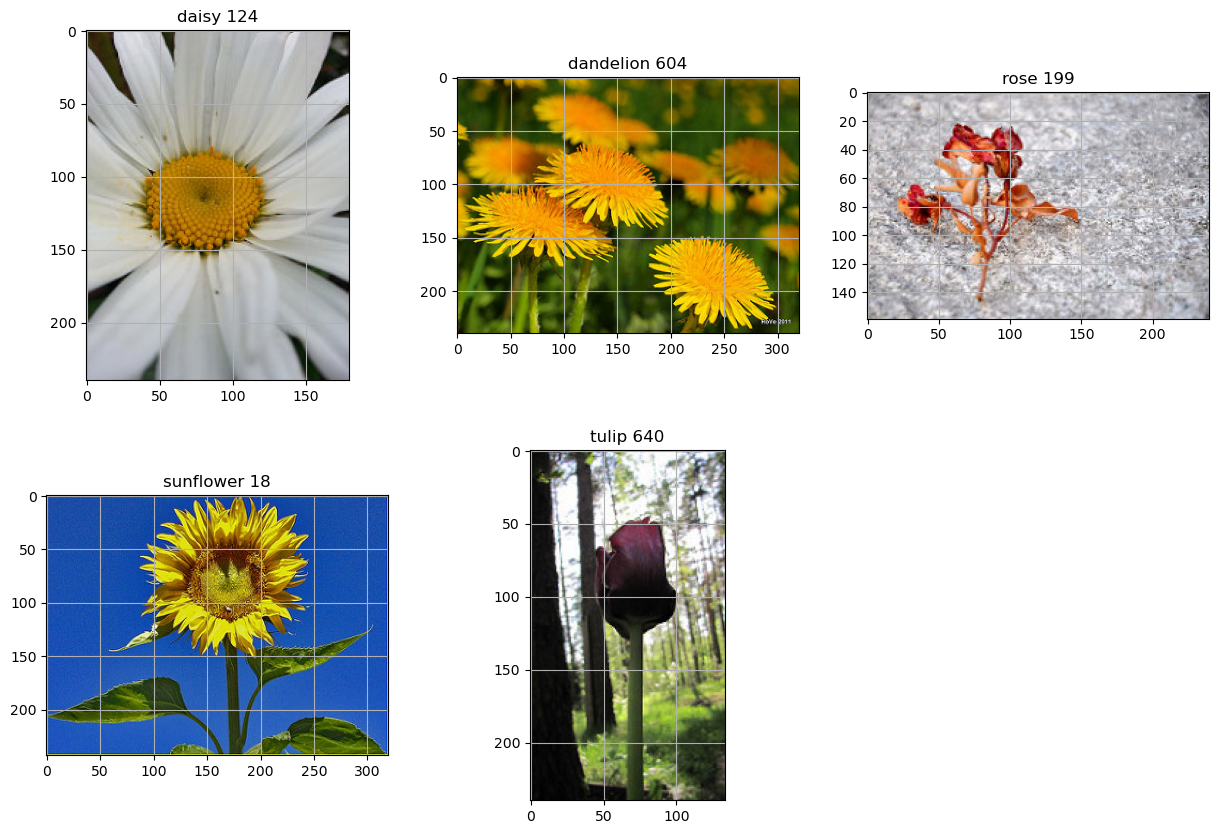

In [6]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

In [7]:
img_width, img_height = 224, 224
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

In [8]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

In [9]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i == 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i == 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[611, 841, 627, 586, 787]
sum of train images: 3452
[153, 211, 157, 147, 197]
sum of val_images: 865


In [10]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [11]:
print('Before converting')
print('train data:', train_images.shape)
print('val data:', val_images.shape)
print('train labels:', train_categories.shape)
print('val labels:', val_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))

print()
print('After converting')
print('train data:', train_data.shape)
print('val data:', val_data.shape)
print('train labels:', train_labels.shape)
print('val labels:', val_labels.shape)

Before converting
train data: (3452, 224, 224, 3)
val data: (865, 224, 224, 3)
train labels: (3452,)
val labels: (865,)

After converting
train data: (3452, 224, 224, 3)
val data: (865, 224, 224, 3)
train labels: (3452, 5)
val labels: (865, 5)


In [12]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [13]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]

In [14]:
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_std_normalization = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=None,
)

train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

/opt/anaconda3/envs/data_analyst/lib/python3.9/site-packages/keras/preprocessing/image.py:1462: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [15]:
train_path = "datasets/train"
test_path = "datasets/test"

In [16]:
numberOfClasses = len(glob(train_path+"/*"))

In [17]:
from keras.applications.vgg16 import VGG16
vgg = VGG16()

2023-05-19 14:33:56.403135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
vgg_layer_list = vgg.layers
vgg_layer_list

In [20]:
model_VGG16 = Sequential()
for i in range(len(vgg_layer_list)-1):
    model_VGG16.add(vgg_layer_list[i])

In [21]:
model_VGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [22]:
for layers in model_VGG16.layers:
    layers.trainable= False
    
model_VGG16.add(Dense(numberOfClasses, activation='softmax'))

In [23]:
model_VGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [24]:
model_VGG16.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [25]:
#train_data = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224))
#test_data = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224))

In [26]:
batch_size = 32
epochs1 = 30

In [27]:
model_VGG16_info = model_VGG16.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)//batch_size,
    epochs=epochs1, 
    validation_steps=len(val_data)//batch_size,
    validation_data=val_generator, 
    verbose=1
)


/var/folders/09/vh1qlc1s4yv5v0qrgr3p6mhm0000gn/T/ipykernel_13344/552870132.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_VGG16_info = model_VGG16.fit_generator(
/opt/anaconda3/envs/data_analyst/lib/python3.9/site-packages/keras/preprocessing/image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/anaconda3/envs/data_analyst/lib/python3.9/site-packages/keras/preprocessing/image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/30
106/106 [==============================] - 1190s 11s/step - loss: 1.5851 - accuracy: 0.4160 - val_loss: 4.8196 - val_accuracy: 0.3750
Epoch 2/30
106/106 [==============================] - 1111s 10s/step - loss: 1.1396 - accuracy: 0.5641 - val_loss: 3.7334 - val_accuracy: 0.5481
Epoch 3/30
106/106 [==============================] - 1042s 10s/step - loss: 1.0071 - accuracy: 0.6122 - val_loss: 4.5223 - val_accuracy: 0.5781
Epoch 4/30
106/106 [==============================] - 990s 9s/step - loss: 0.9398 - accuracy: 0.6449 - val_loss: 5.0189 - val_accuracy: 0.5950
Epoch 5/30
106/106 [==============================] - 991s 9s/step - loss: 0.8868 - accuracy: 0.6764 - val_loss: 4.8428 - val_accuracy: 0.6274
Epoch 6/30
106/106 [==============================] - 1060s 10s/step - loss: 0.8614 - accuracy: 0.6844 - val_loss: 5.0337 - val_accuracy: 0.6238
Epoch 7/30
106/106 [==============================] - 1054s 10s/step - loss: 0.8439 - accuracy: 0.6838 - val_loss: 6.0223 - val_accura

In [28]:
hist = model_VGG16_info

In [29]:
model_VGG16.save_weights("model_VGG16_v2.h5")

In [30]:
import json, codecs
with open("graph_VGG16_v2.json","w") as f:
    json.dump(hist.history,f)

In [31]:
with codecs.open("graph_VGG16_v2.json", encoding="utf-8") as f:
    n = json.loads(f.read())

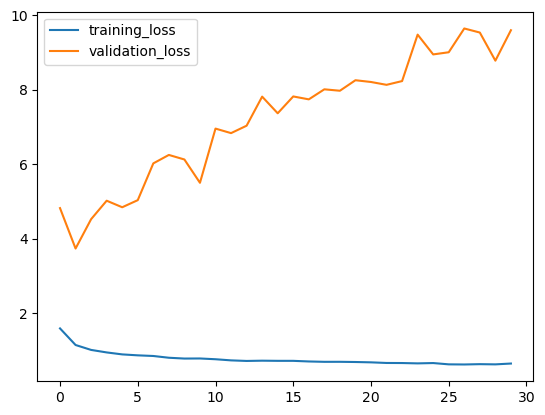

In [32]:
plt.plot(n['loss'], label="training_loss")
plt.plot(n['val_loss'], label="validation_loss")
plt.legend()
plt.show()

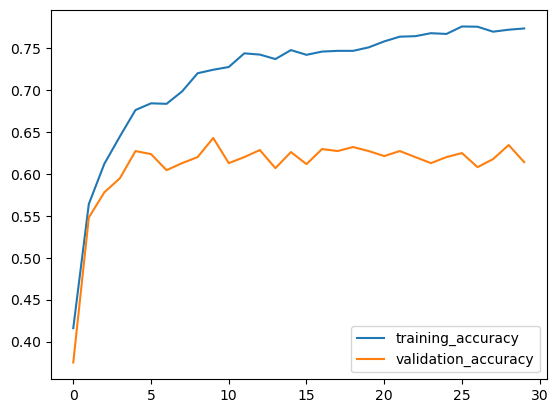

In [33]:
plt.plot(n['accuracy'], label="training_accuracy")
plt.plot(n['val_accuracy'], label="validation_accuracy")
plt.legend()
plt.show()

In [34]:
def predict_val(val_data, model_VGG16):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model_VGG16.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

In [35]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

Model trained from VGG16
1/1 [==============================] - 0s 223ms/step


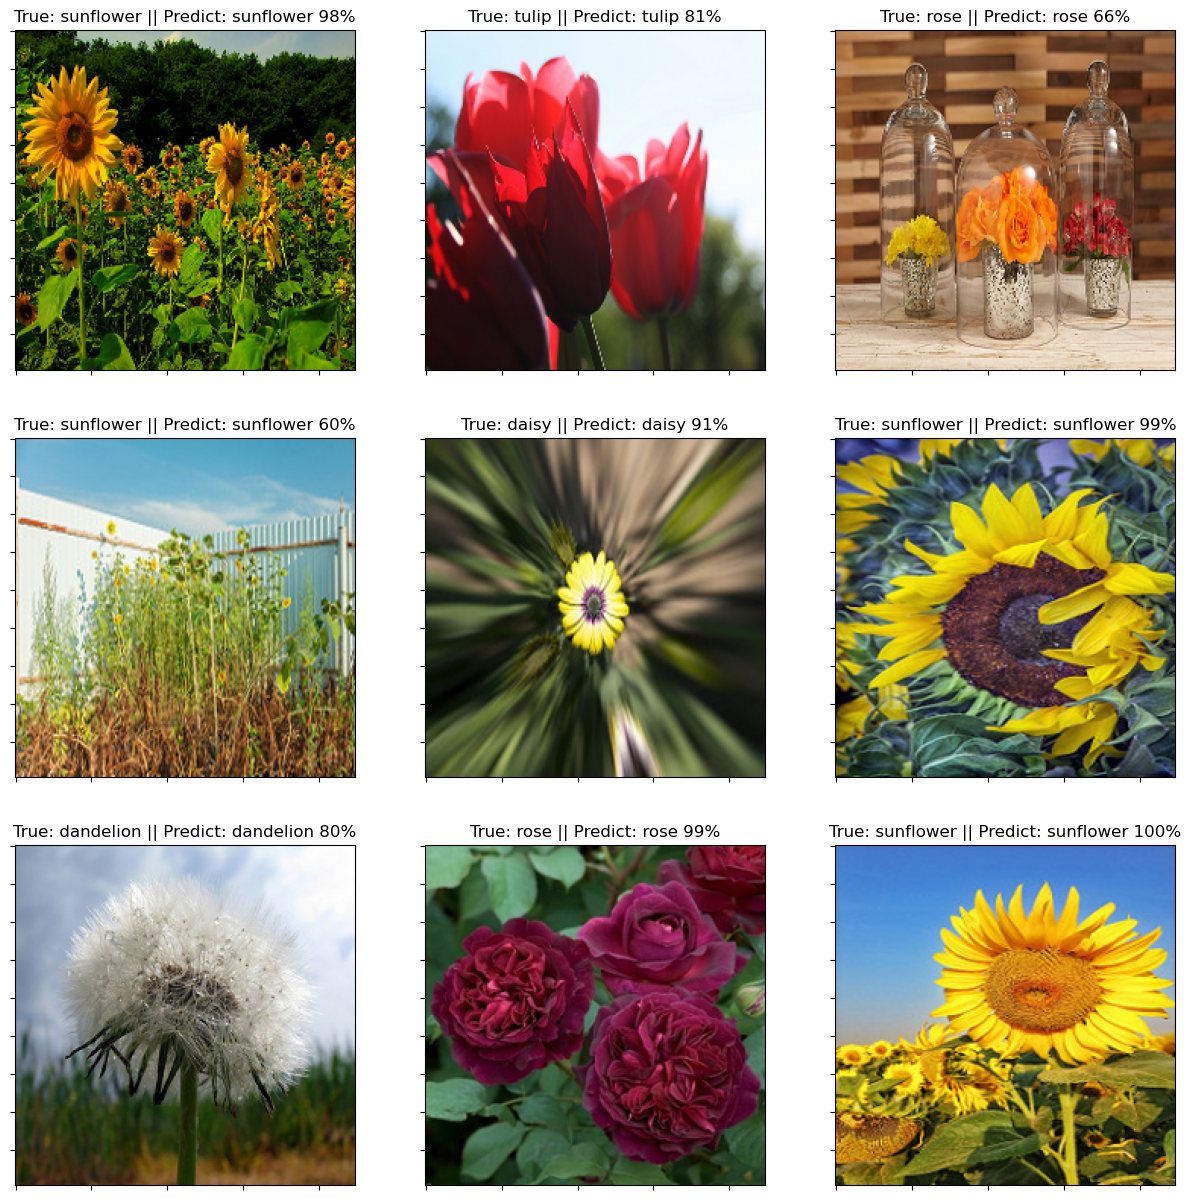

In [37]:
print("Model trained from VGG16")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(860)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
  category_idx = return_name(val_labels[idx])
    
  pred, prob = predict_val(val_data[idx], model_VGG16)
  plt.title('True: %s || Predict: %s %d%%' % (categories[category_idx], categories[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()